In [2]:
from maze2 import Maze, plot_policy, test_agent
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
from tqdm import tqdm
import torch


In [3]:
def seed_everything(env: gym.Env, seed: int = 42)->None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

In [4]:
def plot_tabular_cost_to_go(action_vales, xlabel, ylabel):
    plt.figure(figsize = (8,8))
    cost_to_go = -action_vales.max(axis = -1)
    plt.imshow(cost_to_go, cmap='jet')
    plt.title('Estimated cost-to-go',size = 24)
    plt.xlabel(xlabel, size = 18)
    plt.ylabel(ylabel, size = 18)
    plt.xticks([])
    plt.yticks([])
    plt.xticks()
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [5]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1
    fig, ax = plt.subplots(rows, cols, figsize = (12, 6))
    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
        plt.tight_layout()
        plt.show()

In [6]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [7]:
class TileCodingEnv(gym.ObservationWrapper):
    def __init__(self, env, bins, low, high, n = 4):
        super().__init__(env)
        self.tilings = self._create_tilings(bins, high, low, n)
    
    def observation(self, obs):
        indices = []
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(obs, t))
            indices.append(tiling_indices)
        return indices
    
    def _create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1, 2*len(bins),2)
        tilings = []
        for i in range(1, n+1):
            low_i = low - random.random()* .2* low
            high_i = high + random.random()*.2 * high
            segment_sizes = (high_i - low_i) / bins
            displacements = displacement_vector*(segment_sizes/n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(j,k, l-1) for j,k,l in zip(low_i,high_i, bins)]
            tilings.append(buckets_i)
        return tilings

In [8]:
tilings = 4
bins = np.array([20,20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins = bins, low = low, high = high, n = tilings)

In [9]:
print(f'Modified observation space: {tcenv.observation_space},\n Sample state: {tcenv.reset()}')


Modified observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 Sample state: [(6, 7), (7, 8), (7, 8), (8, 9)]


In [10]:
print(f'Original observation space: {env.observation_space},\n Sample state: {env.reset()}')


Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 Sample state: [-0.5122243  0.       ]


In [11]:
action_values = np.zeros((4,20,20,3))

In [12]:
def policy(state, epsilon = 0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list=[]
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
        av = np.mean(av_list, axis = 0)
        return np.random.choice(np.flatnonzero(av == av.max()))

In [13]:
def sarsa(action_values, policy, episodes, alpha = 0.1, gamma = 0.99, epsilon = 0.2):
    stats = {'Returns':[]}
    for episode in tqdm(range(1, episodes+1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [14]:
stats = sarsa(action_values, policy, 20000, alpha = 0.1, epsilon = 0.)

  0%|          | 3/20000 [00:00<14:00, 23.80it/s]

100%|██████████| 20000/20000 [07:59<00:00, 41.72it/s]


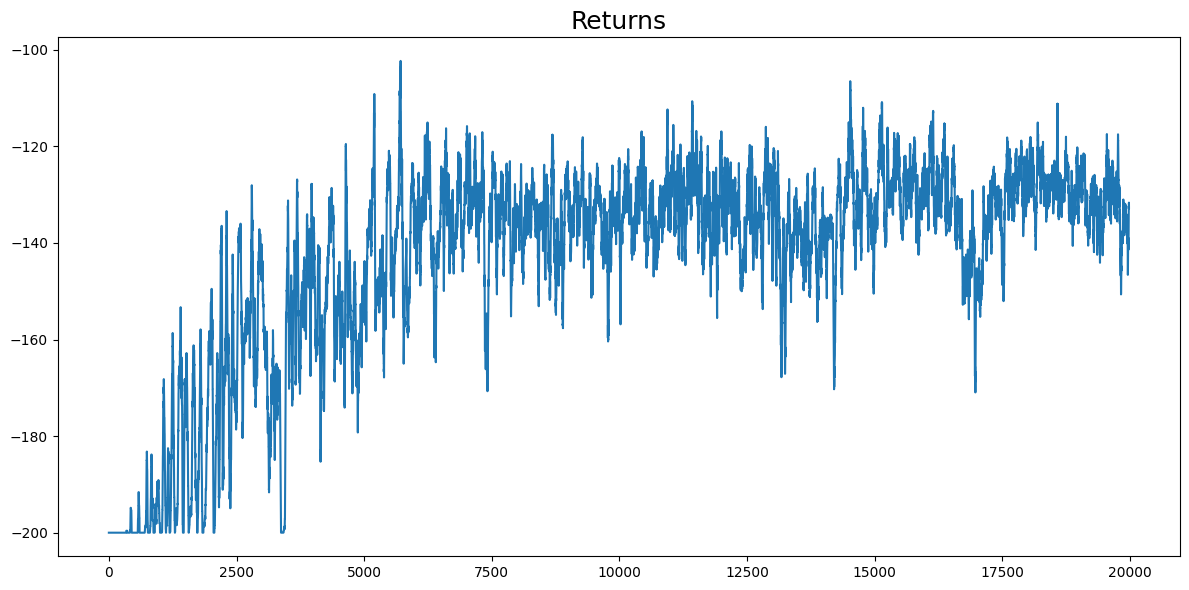

In [15]:
plot_stats(stats)

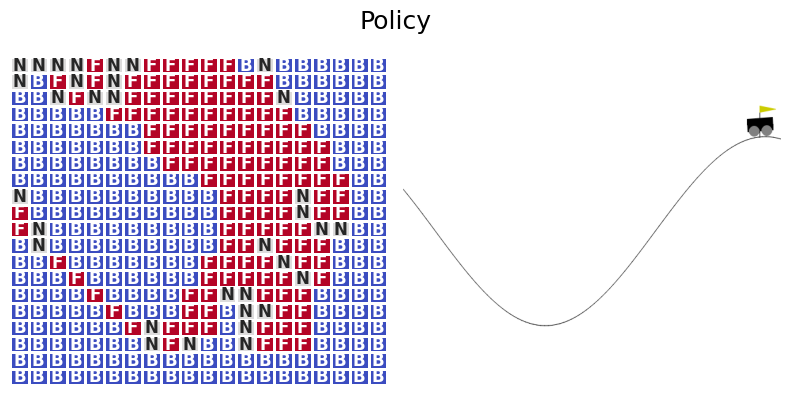

In [16]:
plot_policy(action_values.mean(axis=0), env.render(mode = 'rgb_array'),action_meanings = {0:'B', 1:'N',2:'F'})

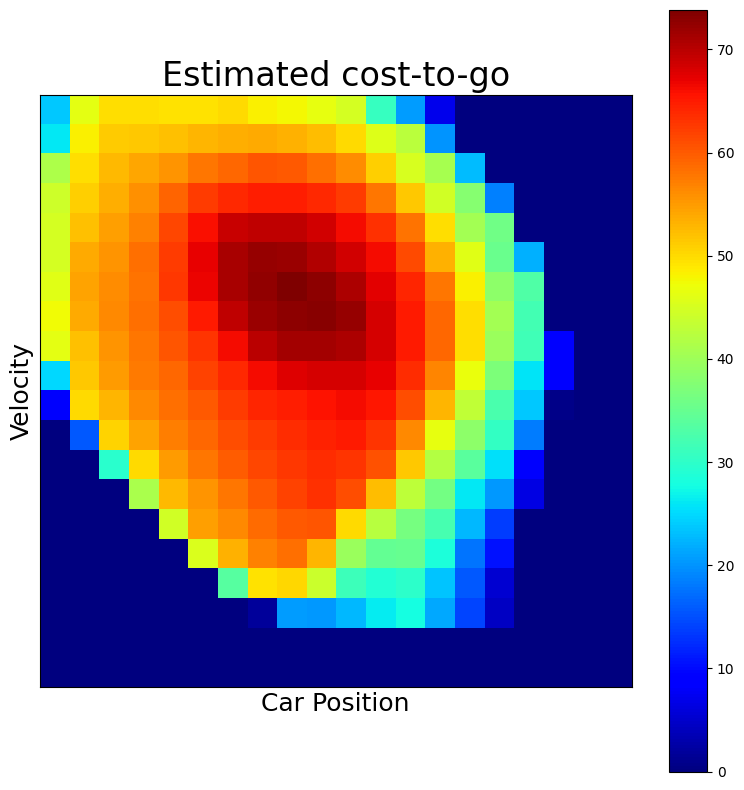

In [17]:
plot_tabular_cost_to_go(action_values.mean(axis =0), xlabel = 'Car Position', ylabel = 'Velocity')

In [18]:
test_agent(tcenv, policy, 2)